# Wrangle WeRateDogs Twitter Data

In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import tweepy
import json
import requests
import cv2
import io
import os
import re
from tqdm import tqdm

pd.set_option('display.max_colwidth', -1)
sns.set()
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)

In [338]:
%ls data

image-predictions.tsv         twitter-archive-enhanced.csv
tweet_json.txt                twitter_archive_master.csv


In [339]:
# Prevent API key from being uploaded on GitHub
%cat .gitignore

credentials.json


# Gathering

In [340]:
# Read dataset
df_tweet = pd.read_csv('data/twitter-archive-enhanced.csv')
df_img = pd.read_csv('data/image-predictions.tsv', delimiter='\t')

In [341]:
df_tweet.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


In [342]:
df_img.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


## Tweepy

In [343]:
def read_cred(cred_path):
    with open(cred_path, 'r') as f:
        return json.load(f)
    
def tweepy_setup():
    cred = read_cred('credentials.json')
    auth = tweepy.OAuthHandler(cred['consumer_key'], cred['consumer_secret'])
    auth.set_access_token(cred['access_token'], cred['access_token_secret'])
    return tweepy.API(auth,  wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


In [344]:
api = tweepy_setup()

def get_tweet_data(tweet_id, prop):
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        return tweet._json[prop]
    except Exception as e:
        print(tweet_id, e)
        return np.nan

fav_count = get_tweet_data(892420643555336193, 'favorite_count')
print(fav_count)

38410


In [345]:
# with open('data/tweet_json.txt', 'w', encoding='UTF-8') as file:
#     for tweet_id in tqdm(df_tweet['tweet_id']):
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             json.dump(tweet._json, file)
#             file.write('\n')
#         except Exception as e:
#             print(str(e))

In [346]:
tweets_data = []
with open('data/tweet_json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweets_data.append(tweet)

columns = ['id', 'retweet_count', 'favorite_count']
df_api = pd.DataFrame(tweets_data, columns=list(tweets_data[0].keys()))
df_api = df_api[columns]
df_api = df_api.rename(columns={'id':'tweet_id'})
df_api.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8439,38422
1,892177421306343426,6221,32900
2,891815181378084864,4119,24792
3,891689557279858688,8559,41748
4,891327558926688256,9298,39911


In [347]:
len(df_tweet) - len(df_api)

15

- 15 tweets no longer exists or cannot be accesed

# Assessing

In [348]:
# Define helper functions to make assessing easy
def get_tweet(col, val):
    return df_tweet[df_tweet[col] == val]

def get_tweet_text(tweet_id):
    return df_tweet[df_tweet['tweet_id'] == tweet_id]['text'].tolist()

def get_img_url(tweet_id):
    return df_img[df_img['tweet_id'] == tweet_id]['jpg_url'].tolist()

def url_to_img(url):
    res = requests.get(url)
    bin_data = io.BytesIO(res.content)
    file_bytes = np.asarray(bytearray(bin_data.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    return img[:, :, ::-1]

def show_tweet(tweet_id):
    text = get_tweet_text(tweet_id)[0]
    img_url = get_img_url(tweet_id)[0]
    print(text)
    plt.imshow(url_to_img(img_url))
    plt.grid(False)
    plt.show()

def list_tweet_url(col, val):
    base_url = 'https://twitter.com/dog_rates/status/'
    for tweet_id in df[df[col] == val]['tweet_id']:
        print(base_url + str(tweet_id))

## twitter-archive-enhanced.csv

In [349]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

- `timestamp` and `retweeted_status_timestamp` shoule be datetime instead of string
- `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` should be integer instead of float
- If `retweeted_status_id` or `in_reply_to_status_id` is not NaN, that means the tweet is retweet or reply. We don't need them. What we want is original ratings with images.

### tweet_id

In [350]:
df_tweet['tweet_id'].nunique()

2356

- `tweet_id` is distinct.

###  name

In [351]:
names = df_tweet['name'].value_counts().index.tolist()
invalid_names = [name for name in names if not name[0].isupper()]
valid_names = list(set(names) - set(invalid_names))

print('Valid names:', valid_names[:10], '\n')
print('Invalid names:', invalid_names[:10])

Valid names: ['Herb', 'Coco', 'Coopson', 'Raphael', 'Benji', 'Al', 'Jimothy', 'Zoe', 'Boots', 'Amber'] 

Invalid names: ['a', 'the', 'an', 'very', 'just', 'quite', 'one', 'getting', 'actually', 'mad']


- `name` has invalid names. Most of WeRateDogs' tweets start with "This is ~" or "Meet ~". So one strategy to parse dog names is extract an word next to "This is ~" or "Meet ~", but this doesn't work for the tweet below. These invalid names should be converted to NaN.

RT @dog_rates: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR


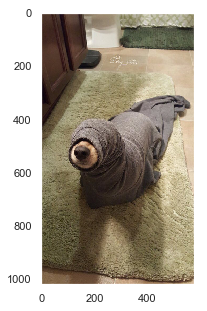

In [352]:
show_tweet(778396591732486144)

### expanded_urls

In [353]:
get_tweet('tweet_id', 838476387338051585)['expanded_urls']

288    https://twitter.com/dog_rates/status/838476387338051585/photo/1,https://twitter.com/dog_rates/status/838476387338051585/photo/1,https://twitter.com/dog_rates/status/838476387338051585/photo/1
Name: expanded_urls, dtype: object

- `expanded_urls` has the same urls. [The tweet above](https://twitter.com/dog_rates/status/838476387338051585) has three same urls which corresponds the number of images attached in the tweet.

### rating_numerator

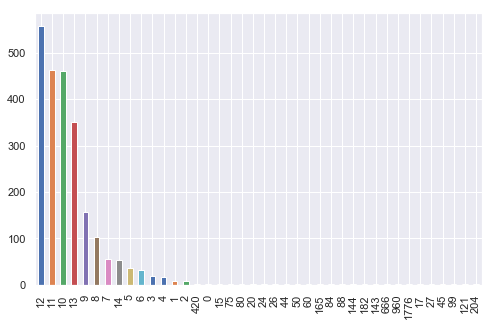

In [354]:
df_tweet['rating_numerator'].value_counts().plot.bar();

In [355]:
regex = r'(\d+\.\d+)\/(\d+)'
df_tweet[df_tweet.text.str.contains(regex)][['text', 'rating_numerator']]

,text,rating_numerator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1689,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26


- There are  decimal ratings. `rating_numerator` in these rows need to be replaced with correct values 

### rating_denominator

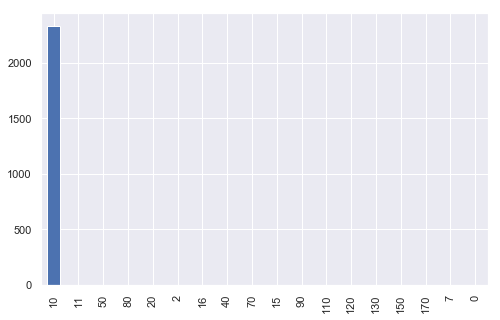

In [356]:
df_tweet['rating_denominator'].value_counts().plot.bar();

In [357]:
df_tweet[df_tweet['rating_denominator'] != 10][['tweet_id', 'text', 'rating_denominator']]

,tweet_id,text,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0
342,832088576586297345,@docmisterio account started on 11/15/15,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50


- 9/11(date), 50/50(ratio), 7/11(convenience store) are extracted as rating. The second match should be extracted

### doggo, loofer, pupper, puppo

In [358]:
cols = ['doggo', 'floofer', 'pupper', 'puppo']

for col in cols: print(df_tweet[col].unique())

['None' 'doggo']
['None' 'floofer']
['None' 'pupper']
['None' 'puppo']


- These columns have only two unique values, so they should be convereted to boolean values to be exploitable.

## image-predictions.tsv

In [359]:
df_img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [360]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


- The number of rows doesn't match that of `df_tweet`.

In [361]:
id_tweet = df_tweet['tweet_id'].values
id_img = df_img['tweet_id'].values

id_diffs1 = np.setdiff1d(id_tweet, id_img)  # tweet_id not included in id_img
id_diffs2 = np.setdiff1d(id_img, id_tweet)  # tweet_id not_included in id_weet

print(len(id_diffs1))
print(len(id_diffs2))

281
0


Some tweets in **twitter-archive-enhanced.csv** are not included in **image-predictions.tsv**. This is because not all tweets in the twitter archive have images.

In [362]:
base_url = 'https://twitter.com/dog_rates/status/'
for tweet_id in np.random.choice(id_diffs1, 10):
    print(base_url + str(tweet_id))

https://twitter.com/dog_rates/status/674742531037511680
https://twitter.com/dog_rates/status/687399393394311168
https://twitter.com/dog_rates/status/822163064745328640
https://twitter.com/dog_rates/status/676121918416756736
https://twitter.com/dog_rates/status/804475857670639616
https://twitter.com/dog_rates/status/825120256414846976
https://twitter.com/dog_rates/status/687399393394311168
https://twitter.com/dog_rates/status/846505985330044928
https://twitter.com/dog_rates/status/840728873075638272
https://twitter.com/dog_rates/status/863471782782697472


The following tweets are **not** included in **image-predictions.tsv**
- Tweet with a video
- Tweet without an image

### jpg_urls

In [363]:
jpg_urls = df_img['jpg_url'].value_counts()
print(jpg_urls.head(5))

https://pbs.twimg.com/media/Co-hmcYXYAASkiG.jpg    2
https://pbs.twimg.com/media/CtzKC7zXEAALfSo.jpg    2
https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg    2
https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg    2
https://pbs.twimg.com/media/CtVAvX-WIAAcGTf.jpg    2
Name: jpg_url, dtype: int64


In [364]:
df_img[df_img['jpg_url'] == jpg_urls.index[4]]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1478,780601303617732608,https://pbs.twimg.com/media/CtVAvX-WIAAcGTf.jpg,1,Saint_Bernard,0.995143,True,Cardigan,0.003044,True,English_springer,0.00105,True
1736,821813639212650496,https://pbs.twimg.com/media/CtVAvX-WIAAcGTf.jpg,1,Saint_Bernard,0.995143,True,Cardigan,0.003044,True,English_springer,0.00105,True


- Duplicates in `jpg_url`

In [365]:
list(filter(lambda x: r'.jpg' not in x, df_img['jpg_url'].tolist()))

['https://pbs.twimg.com/tweet_video_thumb/CVKtH-4WIAAmiQ5.png',
 'https://pbs.twimg.com/tweet_video_thumb/CZ0mhduWkAICSGe.png']

- Two png image urls are included in `jpg_url`.

### predictions

In [366]:
cols = ['p1', 'p2', 'p3']
df_img[cols].sample(10)

,p1,p2,p3
604,llama,ram,chow
1635,chow,Pomeranian,Eskimo_dog
1102,Samoyed,washbasin,tub
1885,Bernese_mountain_dog,Greater_Swiss_Mountain_dog,Appenzeller
1016,bib,handkerchief,umbrella
1231,Pekinese,Shih-Tzu,cocker_spaniel
649,Chihuahua,doormat,toy_terrier
726,pug,bull_mastiff,boxer
913,kuvasz,Great_Pyrenees,Samoyed
621,kuvasz,Samoyed,Great_Pyrenees


Some names start with a small letter, and some start with a capital letter. It's not consistent.

# Assesing Summary

### Quality
**twitter-archive-enhanced.csv**
- Retweets and replies are included
- `timestamp` should be datetime instead of string
- Incorrect rating numerator
- Incorrect rating denominator
- Invalid names in `name` such as 'a', 'an', 'the'

**image-predictions.tsv**
- Duplicates in `jpg_urls`
- Two png image urls are included in `jpg_urls` 
- Not all tweets in the twitter archive have images

### Tidiness
- Three dataframes(df_api, df_tweet, df_img) should be merged together
- Unwanted columns should be removed

**twitter-archive-enhanced.csv**
- `doggo`, `loofer`, `pupper`, `puppo`, these columns needs to be boolean values to be exploitable

**image-predictions.tsv**
- Names in `p1`, `p2`, `p3` are inconsistent. Some start with a capital letter and some with a small letter

# Cleaning

### Define
Merge three dataframe objects

### Code

In [367]:
df = pd.merge(df_tweet, df_img, how='outer')
df = pd.merge(df, df_api, how='outer')
df_copy = df.copy()

### Test

In [368]:
df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8439.0,38422.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6221.0,32900.0


---
### Define
Remove retweets, reply and tweets

### Code

In [369]:
rep_idx = df['in_reply_to_status_id'].isnull()
rwt_idx = df['retweeted_status_id'].isnull()
df = df[rep_idx & rwt_idx]

### Test

In [370]:
print(df['in_reply_to_status_id'].unique())
print(df['in_reply_to_status_id'].unique())

[nan]
[nan]


---
### Define
Convert timestamp to datetime

### Code

In [371]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

### Test

In [372]:
df[['tweet_id', 'timestamp']].dtypes

tweet_id     int64         
timestamp    datetime64[ns]
dtype: object

---
### Defind
Replace incorrect rating `numerator` and `denominator` with correct values

### Code

In [373]:
deci_numerator_idx = df['text'].str.contains(r'(\d+\.\d+\/\d+)')
not_10_denominator_idx = (df['rating_denominator'] != 10)

regex = r'(\d+\.?\d+|\d+)\/(\d+)'
new_ratings = pd.DataFrame(df['text'].str.findall(regex).apply(lambda x: x[-1]).tolist(), index=df.index)
df[['rating_numerator', 'rating_denominator']] = new_ratings

### Test

In [374]:
df[deci_numerator_idx][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.5,10
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10


In [375]:
df[not_10_denominator_idx][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,13,10
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11,10
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


***
### Define
Convert invalid names in `name` to NaN.

### Code

In [376]:
df['name'] = df['name'].apply(lambda x: np.nan if x[0].islower() else x)

### Test

In [377]:
df['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', nan, 'Canela',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven',
       'Beau', 'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante',
       'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash',
       'Jed', 'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie',
       'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha',
       'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jersey', 'H

---
### Define
Convert doggo, floofer, pupper, and puppo to 0 and 1

### Code

In [378]:
cols = ['doggo', 'floofer', 'pupper', 'puppo']

for col in cols:
    df[col] = df[col].apply(lambda x: 1 if x == col else 0)

### Test

In [379]:
df[cols].sample(10)

,doggo,floofer,pupper,puppo
1622,0,0,0,0
1245,0,0,0,0
1096,0,0,1,0
2103,0,0,0,0
1602,0,0,0,0
1745,0,0,0,0
1223,0,0,0,0
496,0,0,0,0
238,0,0,0,0
1033,0,0,0,0


---
### Define
Remove duplicates in jpg_url

### Code

In [380]:
df = df[(~df.duplicated()) | (df['jpg_url'].isnull())]

### Test

In [381]:
df.duplicated('jpg_url').sum()

125

---
### Define
Change the column name `jpg_url` to `img_url`

### Code

In [382]:
df = df.rename(columns={'jpg_url':'img_url'})

### Test

In [383]:
df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'img_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

---
### Define
Capitalize prediction results which start with a small letter.

### Code

In [384]:
cols = ['p1', 'p2', 'p3']

for col in cols:
    df[col] = df[col].apply(lambda x: x.capitalize() if isinstance(x, str) else x)

### Test

In [385]:
df[cols].sample(3)

,p1,p2,p3
1962,Rottweiler,Miniature_pinscher,Appenzeller
2082,American_staffordshire_terrier,Staffordshire_bullterrier,Bull_mastiff
2102,Ibizan_hound,Brittany_spaniel,Chihuahua


---
### Define
Remove unwanted columns.

### Code

In [386]:
cols_to_remove = [
    'in_reply_to_status_id',
    'in_reply_to_user_id',
    'retweeted_status_id',
    'retweeted_status_user_id',
    'retweeted_status_timestamp',
    'expanded_urls'
]

for col in cols_to_remove:
    if col in df.columns:
        df = df.drop(col, axis=1)

### Test

In [387]:
print(any(col in df.columns for col in cols_to_remove))

False


## Feature Engineering
I'll add some new features which might be useful to analyze what relates to the rating, retweet, and favorites.

---
### Define
Add `gender` column which represents dog's gender (1: male, 0: female)

### Code

In [388]:
def get_gender(text):
    text = text.replace('.', '').lower()
    male_words = ['he', 'he\'s', 'his', 'him']
    female_words = ['she', 'she\'s','her', 'hers']
    if any(male_word == word for word in text.split() for male_word in male_words):
        return 'male'
    elif any(female_word == word for word in text.split() for female_word in female_words):
        return 'female'
    else:
        return np.nan
    
df['gender'] = df['text'].apply(get_gender)

### Test

In [389]:
cols = ['text', 'gender']
df_male = df[df['gender'] == 'male'][cols]
df_female = df[df['gender'] == 'female'][cols]
df_unknown = df[df['gender'].isnull()][cols]
pd.concat((df_male.sample(2), df_female.sample(2), df_unknown.sample(2)))

,text,gender
1796,This is Juckson. He's totally on his way to a nascar race. 5/10 for Juckson https://t.co/IoLRvF0Kak,male
2134,This is Randall. He's from Chernobyl. Built playground himself. Has been stuck up there quite a while. 5/10 good dog https://t.co/pzrvc7wKGd,male
812,This is Dixie. She wants to be a ship captain. Won't let anything get in between her and her dreams. 11/10 https://t.co/8VEDZKHddR,female
1161,This is Sugar. She's a Bolivian Superfloof. Spherical af. 12/10 would never let go of https://t.co/AhMfUu6Onm,female
1785,This is a dog swinging. I really enjoyed it so I hope you all do as well. 11/10 https://t.co/Ozo9KHTRND,NaN
1749,This dog doesn't know how to stairs. Quite tragic really. 9/10 get it together pup https://t.co/kTpr9PTMg1,NaN


---
### Define
Add `is_dog` column. WeRateDogs sometimes rates non-dog animals.

### Code

In [390]:
# When WeRateDogs rates non-dog animals, it always complains like "we rate only dogs"
keyword = 'only rate'
df['is_dog'] = df['text'].apply(lambda x: 0 if keyword in x else 1)

### Test

In [391]:
cols = ['text', 'is_dog']
df_dog = df[df['is_dog'] == 1][cols]
df_not_dog = df[df['is_dog'] == 0][cols]
pd.concat((df_dog.sample(2), df_not_dog.sample(2)))

,text,is_dog
1025,This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt,1
198,This is Einstein. He's having a really good day. Hopes you are too. H*ckin nifty tongue. 13/10 would snug intensely https://t.co/mdaQhhfpv6,1
521,"Please only send in dogs. We only rate dogs, not seemingly heartbroken ewoks. Thank you... still 10/10 would console https://t.co/HIraYS1Bzo",0
1077,This... is a Tyrannosaurus rex. We only rate dogs. Please only send in dogs. Thank you ...10/10 https://t.co/zxw8d5g94P,0


---
### Define
Add is_animal column. WeRateDogs sometimes rates rug or carpet which are not even animals.

### Code

In [392]:
df['is_animal'] = df['text'].apply(lambda x: int('without a dog' not in x))

### Test

In [393]:
cols = ['text', 'is_animal']
df_animal = df[df['is_animal'] == 1][cols]
df_not_animal = df[df['is_animal'] == 0][cols]
pd.concat((df_animal.sample(3), df_not_animal.sample(3)))

,text,is_animal
1020,This is Maddie. She gets some wicked air time. Hardcore barkour. 11/10 nimble af https://t.co/bROYbceZ1u,1
1491,Meet Tupawc. He's actually a Christian rapper. Doesn't even understand the concept of dollar signs. 10/10 great guy https://t.co/mCqgtqLDCW,1
925,This is Watson. He trust falls on command. 13/10 it's elementary... (IG: wat.ki) https://t.co/goX3jewkYN,1
112,Real funny guys. Sending in a pic without a dog in it. Hilarious. We'll rate the rug tho because it's giving off a very good vibe. 11/10 https://t.co/GCD1JccCyi,0
814,Another pic without a dog in it? What am I supposed to do? Rate the carpet? Fine I will. 7/10 looks adequately comfy https://t.co/OJZQ6I4gGd,0
912,Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl,0


### Final result

In [394]:
print('The number of rows', len(df))
df.head()

The number of rows 2097


,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,gender,is_dog,is_animal
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,0,0,0,...,0.085851,False,Banana,0.076110,False,8439.0,38422.0,male,1,1
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13,10,Tilly,0,0,0,...,0.090647,True,Papillon,0.068957,True,6221.0,32900.0,female,1,1
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,0,0,0,...,0.078253,True,Kelpie,0.031379,True,4119.0,24792.0,male,1,1
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,0,0,0,...,0.168086,True,Spatula,0.040836,False,8559.0,41748.0,female,1,1
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12,10,Franklin,0,0,0,...,0.225770,True,German_short-haired_pointer,0.175219,True,9298.0,39911.0,male,1,1


# Storing

In [395]:
df.to_csv('data/twitter_archive_master.csv', index=False)

# Analyzing and Visualizing

In [396]:
df = pd.read_csv('data/twitter_archive_master.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

## gender

In [397]:
ratio_female = (df['gender'] == 'female').mean()
ratio_male = (df['gender'] == 'male').mean()
ratio_unknown = 1 - (ratio_female + ratio_male)
print('Female ratio:', round(ratio_female, 2), '%')
print('Male ratio:', round(ratio_male, 2), '%')
print('Gender unknown:', round(ratio_unknown, 2), '%')

Female ratio: 0.17 %
Male ratio: 0.51 %
Gender unknown: 0.32 %


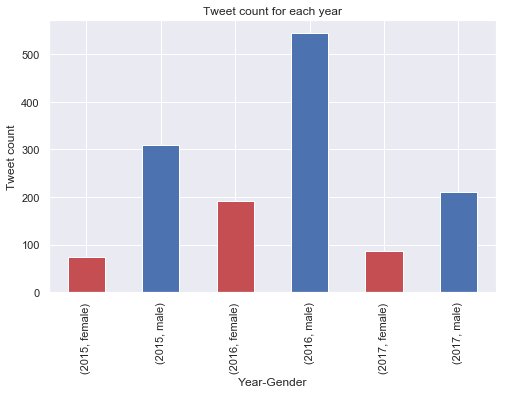

In [398]:
twt_cnt = df.groupby([df['timestamp'].dt.year, 'gender']).size()
twt_cnt.plot.bar(color=['r', 'b']*3)
plt.title('Tweet count for each year')
plt.xlabel('Year-Gender')
plt.ylabel('Tweet count');

The number of male dogs is much larger than that of female dogs for each year. WeRageDogs tweets about dog's cute and funny behavior. Are male dogs more likely to do something cute and funny or does WeRateDogs like male dogs? 

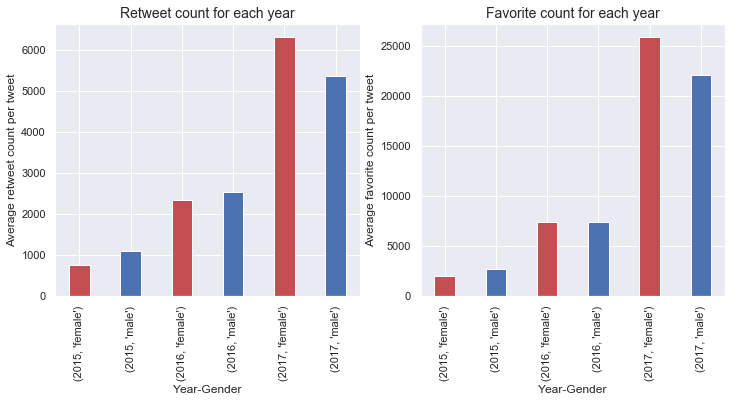

In [399]:
def plot_bar(ax, ser, xlabel, ylabel, title, xticklabels=None, color=['r', 'b'], rotation=0):
    """Helper function to plot a bar chart"""
    x = np.arange(len(ser))
    xticklabels = xticklabels if xticklabels else ser.index
    ax.bar(x, ser, color=color*int(len(ser) / 2), width=0.4)
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels, rotation=rotation)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

ret_ave = df.groupby([df['timestamp'].dt.year, 'gender']).mean()['retweet_count']
fav_ave = df.groupby([df['timestamp'].dt.year, 'gender']).mean()['favorite_count']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_bar(ax1, ret_ave, 'Year-Gender', 'Average retweet count per tweet', 'Retweet count for each year', rotation=90)
plot_bar(ax2, fav_ave, 'Year-Gender', 'Average favorite count per tweet', 'Favorite count for each year', rotation=90)

- The average retweet and favorite count per tweet is increasing year by year. This means the popularity of WeRateDogs is increasing.
- In 2017, female dogs have more retweet and favorites.

Text(0.5,1,'Rating numerator for male and female')

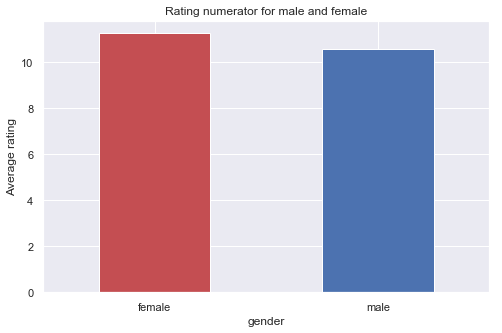

In [400]:
# Remove outliers? in rating_numerator
df['rating_numerator_clean'] = df['rating_numerator'].apply(lambda x: x if x <= 15 else np.nan)

df.groupby('gender').mean()['rating_numerator_clean'].plot.bar(color=['r', 'b'])
plt.xticks(rotation=0)
plt.ylabel('Average rating');
plt.title('Rating numerator for male and female')

- The average rating is over 10.
- Male dogs have a slightly higher ratings compared to male dogs. 

##  is_dog

In [401]:
twt_cnt = df.groupby('is_dog').size()
twt_cnt

is_dog
0    54  
1    2043
dtype: int64

54 non-dog animals are included in this dataset.

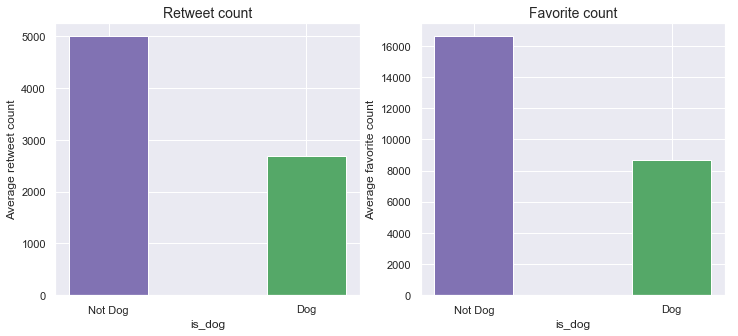

In [402]:
ret_ave = df.groupby('is_dog').mean()['retweet_count']
fav_ave = df.groupby('is_dog').mean()['favorite_count']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_bar(ax1, ret_ave, 'is_dog', 'Average retweet count', 'Retweet count', xticklabels=['Not Dog', 'Dog'], color=['m', 'g'])
plot_bar(ax2, fav_ave, 'is_dog', 'Average favorite count', 'Favorite count', xticklabels=['Not Dog', 'Dog'], color=['m', 'g'])

Animals that are not dogs have about twice more retweets and favorites! This makes sense because the best part of WeRateDogs is when it rates non-dog animals (they are actually dogs most of time) with hilarious comments.

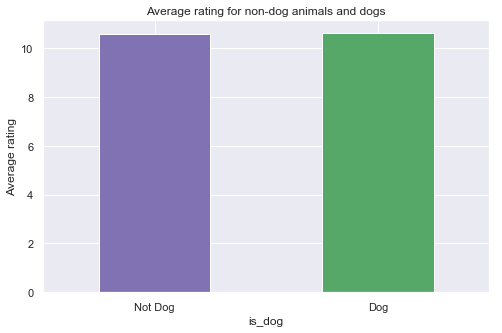

In [403]:
df.groupby('is_dog').mean()['rating_numerator_clean'].plot.bar(color=['m', 'g'])
plt.xticks(plt.xticks()[0], ['Not Dog', 'Dog'], rotation=0)
plt.ylabel('Average rating')
plt.title('Average rating for non-dog animals and dogs');

They look almost the same. So we can conclude that WeRateDogs gives a fair rating for non-dog animals even though it always complains when people send them.

## is_animal

In [404]:
df[df['is_animal'] == 0][['tweet_id', 'text']]

,tweet_id,text
97,870804317367881728,Real funny guys. Sending in a pic without a dog in it. Hilarious. We'll rate the rug tho because it's giving off a very good vibe. 11/10 https://t.co/GCD1JccCyi
628,771014301343748096,Another pic without a dog in it? What am I supposed to do? Rate the carpet? Fine I will. 7/10 looks adequately comfy https://t.co/OJZQ6I4gGd
708,757596066325864448,Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl
779,748977405889503236,What jokester sent in a pic without a dog in it? This is not @rock_rates. This is @dog_rates. Thank you ...10/10 https://t.co/nDPaYHrtNX
1247,693647888581312512,What kind of person sends in a pic without a dog in it? So churlish. Neat rug tho 7/10 https://t.co/LSTAwTdTaw
1625,675153376133427200,What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table https://t.co/RDXCfk8hK0


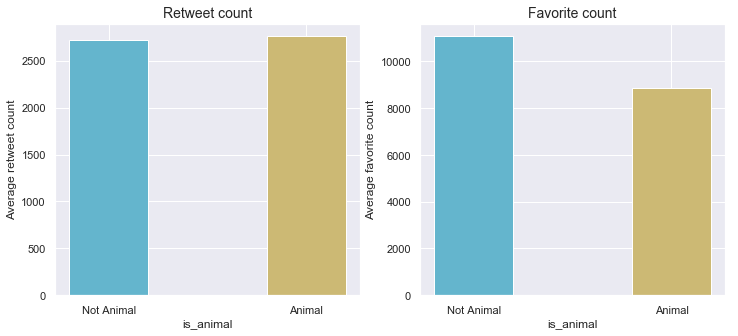

In [405]:
ret_ave = df.groupby('is_animal').mean()['retweet_count']
fav_ave = df.groupby('is_animal').mean()['favorite_count']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
plot_bar(ax1, ret_ave, 'is_animal', 'Average retweet count', 'Retweet count', xticklabels=['Not Animal', 'Animal'], color=['c', 'y'])
plot_bar(ax2, fav_ave, 'is_animal', 'Average favorite count', 'Favorite count', xticklabels=['Not Animal', 'Animal'], color=['c', 'y'])

Text(0.5,1,'Average rating for non-dog animals and dogs')

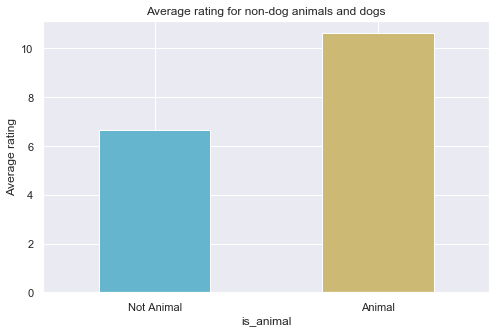

In [406]:
df.groupby('is_animal').mean()['rating_numerator_clean'].plot.bar(color=['c', 'y'])
plt.xticks(plt.xticks()[0], ['Not Animal', 'Animal'], rotation=0)
plt.ylabel('Average rating')
plt.title('Average rating for non-dog animals and dogs')

The reliability of these results is skeptical because the number of samples in 'without_dog' is only 6 which is very small. But pictures without a dog in it tend to get rated very low even though they get more favorates.

# Conclusion
1. WeRateDogs often tweets male dogs.
1. The popularity of WeRateDogs is increasing. 
2. Non-dog animals are likely to get more retweets and favoriates than dogs.
2. WeRateDogs is a fair rater even for non-dog animals, but very strict with people sending in pictures without a dog in it.
